In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
df = pd.read_csv("who.csv")


In [4]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [5]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [6]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Numeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

Numeric Columns: Index(['Year', 'Life expectancy ', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')
Categorical Columns: Index(['Country', 'Status'], dtype='object')


In [7]:
num_imputer = SimpleImputer(strategy='median')
df_numeric = pd.DataFrame(num_imputer.fit_transform(df[numeric_cols]),
                          columns=numeric_cols)

In [8]:
cat_imputer = SimpleImputer(strategy='most_frequent')
df_categorical = pd.DataFrame(cat_imputer.fit_transform(df[categorical_cols]),
                              columns=categorical_cols)

In [9]:
df_clean = pd.concat([df_numeric, df_categorical], axis=1)

In [10]:
df_clean.isnull().sum()

Year                               0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
Country                            0
Status                             0
dtype: int64

In [11]:
df = df.dropna(subset=["Life expectancy "])
X = df_clean.drop("Life expectancy ", axis=1)
y = df_clean["Life expectancy "]


In [12]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

In [13]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [14]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", TargetEncoder(cols=cat_cols), cat_cols)
    ]
)

In [15]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline 


lasso_selector = Pipeline([
    ("preprocess", preprocess),
    ("selector", SelectFromModel(Lasso(alpha=0.01, max_iter=1000)))
])

lasso_selector.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Year', 'Adult Mortality', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')),
                                                 ('cat',
                                                  TargetEncoder(cols=Index(['Country', 'Status'], dtype='object')),
                                                  Index(['Country', 'Status'], dtype='object'))])),
                ('selector', SelectFromModel(estimator=Lasso(alpha=0.01)))])

In [16]:
mask_lasso = lasso_selector.named_steps["selector"].get_support()

feature_names = lasso_selector.named_steps["preprocess"].get_feature_names_out()
selected_features = feature_names[mask_lasso]

print("Selected Features by LASSO:")
print(selected_features)

Selected Features by LASSO:
['num__Year' 'num__Adult Mortality' 'num__Alcohol'
 'num__percentage expenditure' 'num__Hepatitis B' 'num__Measles '
 'num__ BMI ' 'num__under-five deaths ' 'num__Polio' 'num__Diphtheria '
 'num__ HIV/AIDS' 'num__GDP' 'num__ thinness 5-9 years'
 'num__Income composition of resources' 'num__Schooling' 'cat__Country'
 'cat__Status']


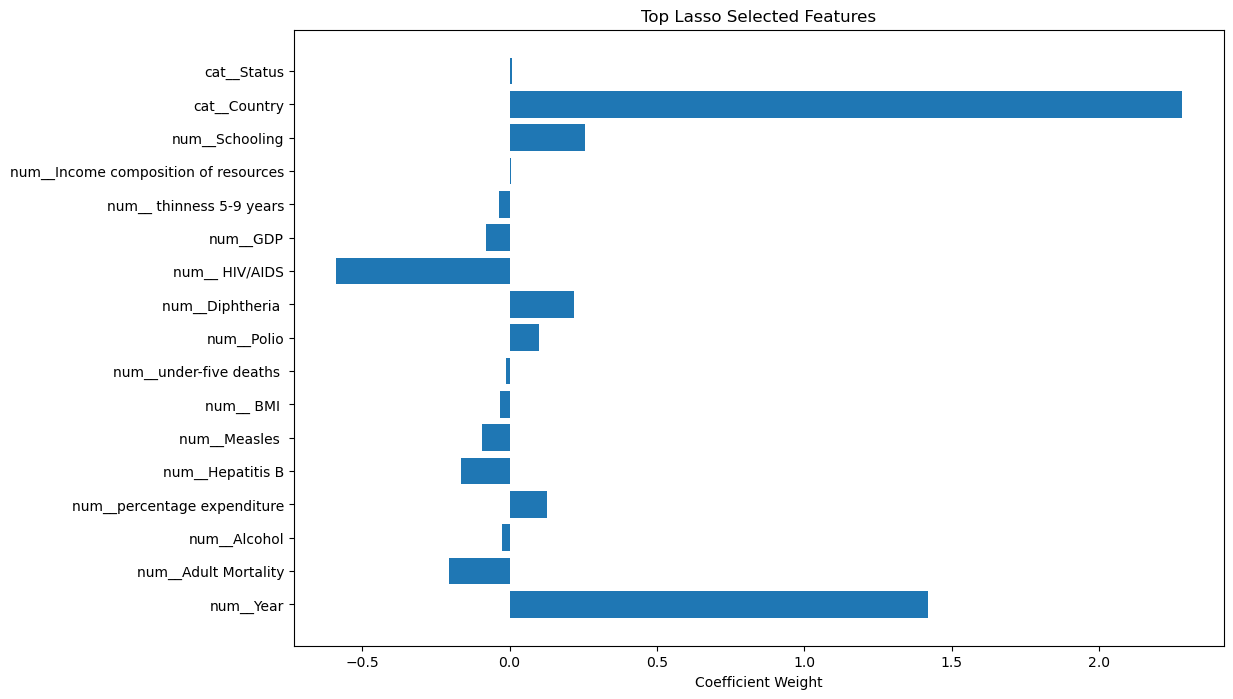

In [17]:
import matplotlib.pyplot as plt
lasso_model = Pipeline([
    ("preprocess", preprocess),
    ("model", Lasso(alpha=0.01, max_iter=1000))
])

lasso_model.fit(X, y)

feature_names = lasso_model.named_steps["preprocess"].get_feature_names_out()
coeff = lasso_model.named_steps["model"].coef_

# Plot non-zero coefficients
non_zero_idx = coeff != 0

plt.figure(figsize=(12, 8))
plt.barh(feature_names[non_zero_idx][:20], coeff[non_zero_idx][:20])
plt.xlabel("Coefficient Weight")
plt.title("Top Lasso Selected Features")
plt.show()

In [18]:
X_selected = lasso_selector.named_steps["preprocess"].transform(X)[:, mask_lasso]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
y_pred = lr.predict(X_test)

In [22]:
r2_lr = r2_score(y_test, y_pred)
mae_lr= mean_absolute_error(y_test, y_pred)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
print("Linear Regression Performance:")
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

Linear Regression Performance:
R²: 0.9628
MAE: 1.1681
RMSE: 1.7944


In [23]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [24]:
y_pred_rf = rf.predict(X_test)

In [25]:
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

In [26]:
print("Random Forest Performance:\n")
print(f"R²={r2_rf:.4f}, MAE={mae_rf:.4f}, RMSE={rmse_rf:.4f}")

Random Forest Performance:

R²=0.9774, MAE=0.8164, RMSE=1.3982


In [27]:
gb = GradientBoostingRegressor(n_estimators=200, random_state=42)
gb.fit(X_train, y_train)


GradientBoostingRegressor(n_estimators=200, random_state=42)

In [28]:
y_pred_gb = gb.predict(X_test)

In [29]:
r2_gb = r2_score(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

In [30]:
print("Gradient Boosting Performance:\n")
print(f"R²={r2_gb:.4f}, MAE={mae_gb:.4f}, RMSE={rmse_gb:.4f}")

Gradient Boosting Performance:

R²=0.9712, MAE=1.0108, RMSE=1.5812


In [31]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [32]:
y_pred = xgb_model.predict(X_test)

In [33]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2_xgb = r2_score(y_test, y_pred)

In [34]:
print("XGBoost Regression Results:")
print(f"MAE  : {mae:.4f},MSE : {mse:.4f} , RMSE : {rmse:.4f} ,R² : {r2_xgb:.4f}")

XGBoost Regression Results:
MAE  : 0.8178,MSE : 1.8547 , RMSE : 1.3619 ,R² : 0.9786


In [35]:
plt.figure(figsize=(15,10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0, 0.5, 'Predicted')

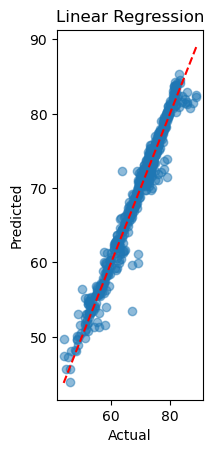

In [36]:
plt.subplot(1, 3, 1)
plt.scatter(y_test, lr.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Linear Regression")
plt.xlabel("Actual")
plt.ylabel("Predicted")


Text(0, 0.5, 'Predicted')

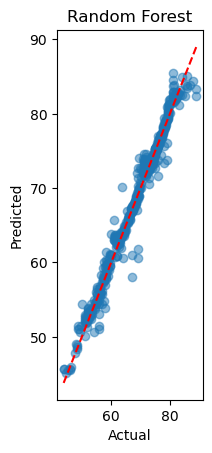

In [37]:
plt.subplot(1, 3, 2)
plt.scatter(y_test, rf.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Actual")
plt.ylabel("Predicted")

Text(0, 0.5, 'Predicted')

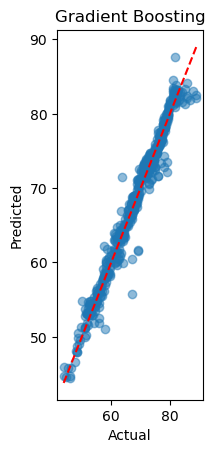

In [38]:
plt.subplot(1, 3, 3)
plt.scatter(y_test, gb.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Gradient Boosting")
plt.xlabel("Actual")
plt.ylabel("Predicted")

Text(0, 0.5, 'Predicted')

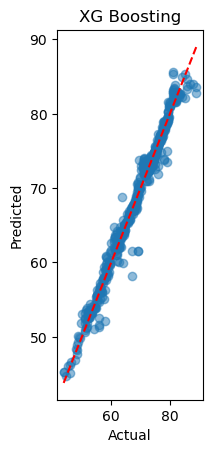

In [39]:
plt.subplot(1, 3, 3)
plt.scatter(y_test, xgb_model.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("XG Boosting")
plt.xlabel("Actual")
plt.ylabel("Predicted")

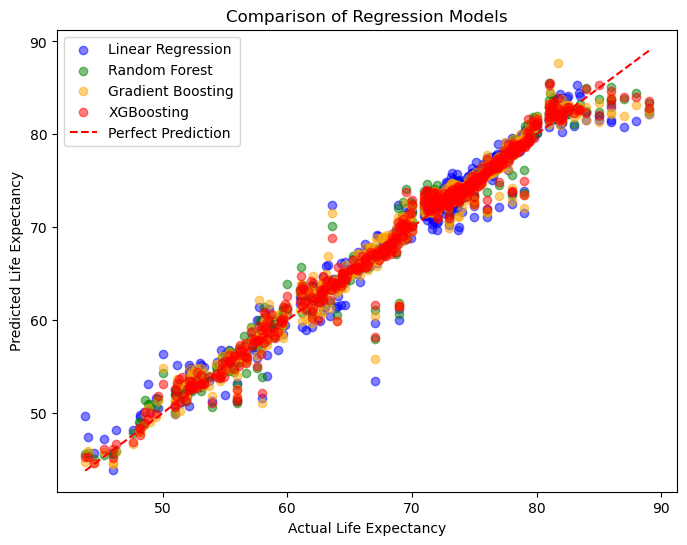

In [41]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, lr.predict(X_test), alpha=0.5, label='Linear Regression', color='blue')
plt.scatter(y_test, rf.predict(X_test), alpha=0.5, label='Random Forest', color='green')
plt.scatter(y_test, gb.predict(X_test), alpha=0.5, label='Gradient Boosting', color='orange')
plt.scatter(y_test, xgb_model.predict(X_test), alpha=0.5, label='XGBoosting', color='red')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Comparison of Regression Models')
plt.legend()
plt.show()

In [42]:
r2_scores = {
    "Linear": r2_lr,
    "RandomForest": r2_rf,
    "GradientBoost": r2_gb,
    "XGBoost": r2_xgb
}


In [43]:
models = list(r2_scores.keys())
scores = list(r2_scores.values())


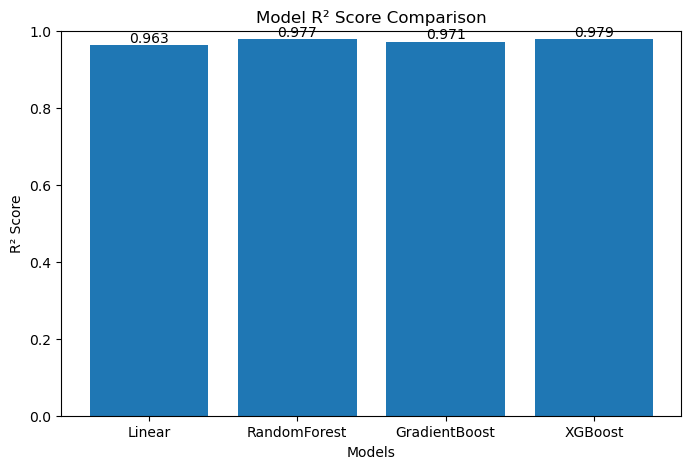

In [44]:
plt.figure(figsize=(8, 5))
bars = plt.bar(models, scores)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f"{height:.3f}", ha='center', va='bottom')

plt.title("Model R² Score Comparison")
plt.ylabel("R² Score")
plt.xlabel("Models")
plt.ylim(0, 1) 

plt.show()

In [45]:
import pickle
with open("preprocessor.pkl", "wb") as f:
    pickle.dump(preprocess, f)
with open("selected_features.pkl", "wb") as f:
    pickle.dump(selected_features, f)
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
print("pickle files saved successfully")


pickle files saved successfully
